# Exercise on multiple Markov chains (MMC)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numba

In [2]:
# Parameters
c = 1 
monomer_radius = c / 2
x_initial,y_initial = (0, 0)
bond_length_min, bond_length_max = (1, 1.3)
n_monomers = 20
epsilon_energy = 1
energy_threshold = 0.5

## Geometry

In [3]:
#initial configuration (vertical stick)
monomers_initial_conf=np.zeros((n_monomers,2))
bond = 1.15
for i in range (1, n_monomers):
    monomers_initial_conf[i][1]=i*bond*c

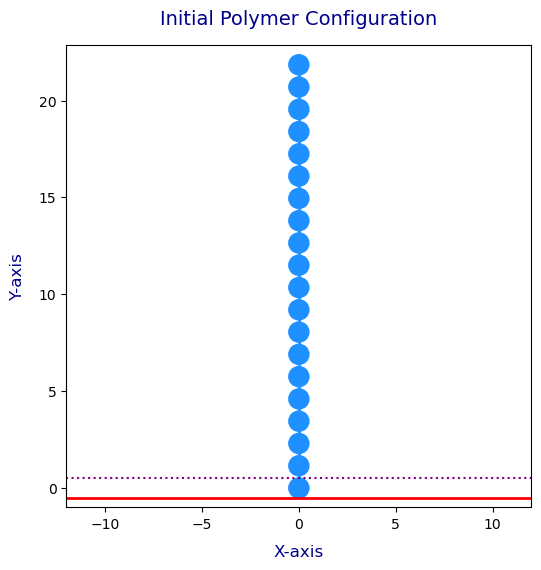

In [4]:
# Initial configuration plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal', adjustable='datalim')

for i, point in enumerate(monomers_initial_conf):
    circle = plt.Circle((point[0], point[1]), 0.5, color='dodgerblue', alpha=1,linewidth=1.5)
    ax.add_patch(circle)
    if i > 0:
        prev_point = monomers_initial_conf[i - 1]
        ax.plot([prev_point[0], point[0]], [prev_point[1], point[1]], color='dodgerblue', linewidth=2)

ax.set_xlim(min(p[0] for p in monomers_initial_conf) - 1, max(p[0] for p in monomers_initial_conf) + 1)
ax.set_ylim(min(p[1] for p in monomers_initial_conf) - 1, max(p[1] for p in monomers_initial_conf) + 1)
ax.axhline(y=-monomer_radius, color='red', linestyle='-', linewidth=2, label="Wall")
ax.axhline(y=energy_threshold, color='purple', linestyle=':', linewidth=1.5, label="Energy Threshold")
ax.set_xlabel("X-axis", fontsize=12, labelpad=10, color='darkblue')
ax.set_ylabel("Y-axis", fontsize=12, labelpad=10, color='darkblue')
ax.set_title("Initial Polymer Configuration", fontsize=14, color='darkblue', pad=15)

plt.show()

In [5]:
@numba.njit
def polymer_displacement(configuration):
    sigma = monomer_radius/4
    shift_conf = np.zeros((n_monomers,2))
    valid_configuration = False
    # ---- Move generation
    while (not valid_configuration): # Local shifts move
        for i in range(1,n_monomers):
            shift_conf[i][0]=configuration[i][0] + np.random.normal(0, sigma)
            shift_conf[i][1]=configuration[i][1] + np.random.normal(0, sigma)
        max_angle = np.pi # Pivot rotation move
        angle = np.random.uniform(-max_angle, max_angle)
        pivot = np.random.randint(0, n_monomers)  # Ensure pivot is an integer index
        new_conf = shift_conf   
        for i in range(pivot, n_monomers): # Apply rotation around the pivot point
            dx = shift_conf[i][0] - shift_conf[pivot][0]
            dy = shift_conf[i][1] - shift_conf[pivot][1]
            new_conf[i] = (
                dx * np.cos(angle) - dy * np.sin(angle) + shift_conf[pivot][0],
                dx * np.sin(angle) + dy * np.cos(angle) + shift_conf[pivot][1]
            )
    # ----- Geometry constraints
        valid_configuration = True # Check bond length constraint
        for i in range(n_monomers - 1):
            bond_length = np.sqrt((new_conf[i+1][0] - new_conf[i][0]) ** 2 + (new_conf[i+1][1] - new_conf[i][1]) ** 2)
            if not (bond_length_min <= bond_length <= bond_length_max):
                valid_configuration = False
        for monomer in new_conf: # Check hard wall constraint
            if monomer[1] < 0: 
                valid_configuration = False
        for i in range(n_monomers):# Check minimum distance between monomer centers
            for j in range(i + 1, n_monomers):
                center_distance = np.sqrt((new_conf[i][0] - new_conf[j][0]) ** 2 + (new_conf[i][1] - new_conf[j][1]) ** 2)
                if center_distance < 2 * monomer_radius:
                        valid_configuration = False
    return new_conf

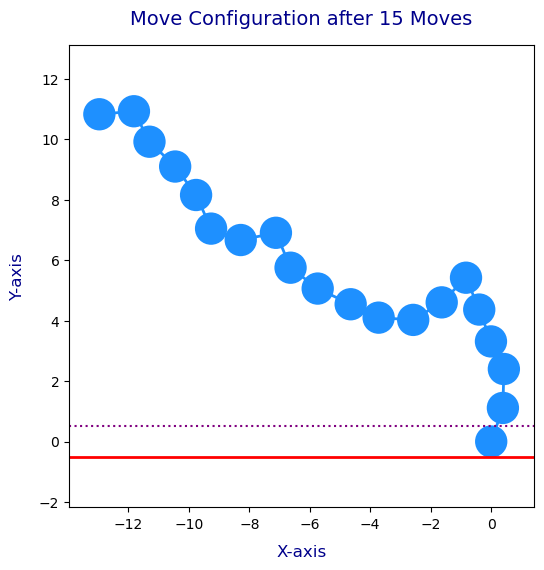

In [6]:
total_moves=15

configurations=np.zeros((total_moves, n_monomers, 2))
configurations[0]=monomers_initial_conf

for i in range(1,total_moves):
    configurations[i]=polymer_displacement(configurations[i-1])

conf=configurations[total_moves-1]

# Move plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal', adjustable='datalim')

for i, point in enumerate(conf):
    circle = plt.Circle((point[0], point[1]), 0.5, color='dodgerblue', alpha=1,linewidth=1.5)
    ax.add_patch(circle)
    if i > 0:
        prev_point = conf[i - 1]
        ax.plot([prev_point[0], point[0]], [prev_point[1], point[1]], color='dodgerblue', linewidth=2)

ax.set_xlim(min(p[0] for p in conf) - 1, max(p[0] for p in conf) + 1)
ax.set_ylim(min(p[1] for p in conf) - 1, max(p[1] for p in conf) + 1)
ax.axhline(y=-monomer_radius, color='red', linestyle='-', linewidth=2, label="Wall")
ax.axhline(y=energy_threshold, color='purple', linestyle=':', linewidth=1.5, label="Energy Threshold")
ax.set_xlabel("X-axis", fontsize=12, labelpad=10, color='darkblue')
ax.set_ylabel("Y-axis", fontsize=12, labelpad=10, color='darkblue')
ax.set_title(f"Move Configuration after {total_moves} Moves", fontsize=14, color='darkblue', pad=15)

plt.show()

## Thermalization process

We study in this paragraph, for a fixed $\beta$, the energy evolution, the end-end distance evolution and the height of the end evolution

In [7]:
@numba.njit(cache=True)
def end2end_distance_squared (configuration : np.ndarray) -> np.float64:
    return np.sqrt((configuration[-1][0]- configuration[0][0])**2+(configuration[-1][1]- configuration[0][1])**2)

@numba.njit(cache=True)
def energy (configuration : np.ndarray) -> np.float64:
    energy = 0
    for point in configuration:
        if point[1]<energy_threshold: energy-=epsilon_energy
    return energy

@numba.njit(cache=True)
def metropolis (old_configuration : np.ndarray, new_configuration : np.ndarray, beta : float) -> np.float64:
    delta_Energy=energy(new_configuration)-energy(old_configuration)
    if delta_Energy <= 0: return True
    elif np.random.random() <= np.exp(- beta * delta_Energy ) : return True
    return False            

In [8]:
time_max=500

@numba.njit
def thermalization(beta : np.float64) -> (np.ndarray,np.ndarray,np.ndarray) :
    moves=np.zeros((time_max, n_monomers, 2))
    moves[0]=monomers_initial_conf
    ee2=np.zeros((time_max))
    energy_list=np.zeros((time_max))
    end_heigth=np.zeros((time_max))
    for i in range(1, time_max):
        moves[i] = polymer_displacement(moves[i-1])
        if not metropolis(moves[i-1],moves[i], beta): moves[i] = moves[i-1]
        ee2[i] = end2end_distance_squared(moves[i])
        end_heigth[i]=moves[i,n_monomers-1,1]
        energy_list[i]=energy(moves[i])
    return ee2, end_heigth, energy_list

In [9]:
x=np.arange(0,time_max,1)

beta_list =np.linspace(5, 50, 6)

ee2_results = np.zeros((len(beta_list), time_max))
end_height_results = np.zeros((len(beta_list), time_max))
energy_evolution_results = np.zeros((len(beta_list), time_max))

In [10]:
for k, beta in enumerate(beta_list):
    ee2_results[k], end_height_results[k], energy_evolution_results[k] = thermalization(beta)
    print(f"siamo alla fine del {k+1} beta")

siamo alla fine del 1 beta
siamo alla fine del 2 beta
siamo alla fine del 3 beta
siamo alla fine del 4 beta
siamo alla fine del 5 beta
siamo alla fine del 6 beta


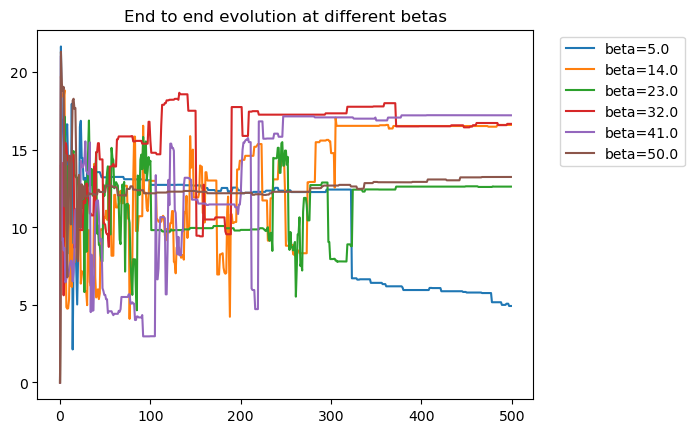

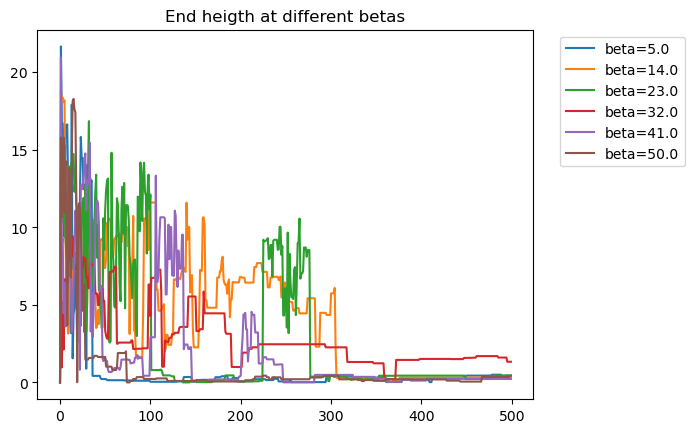

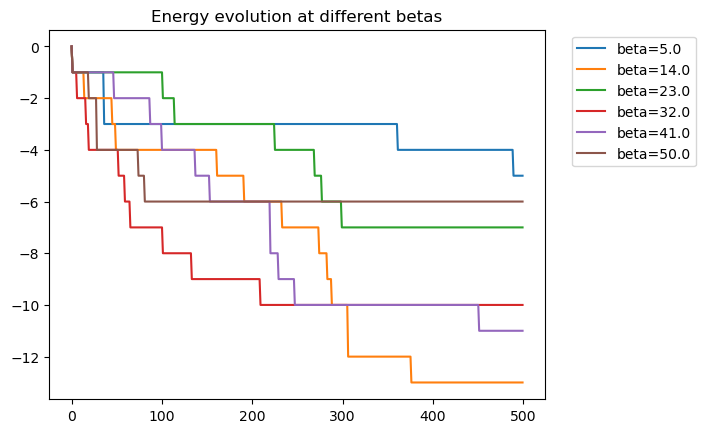

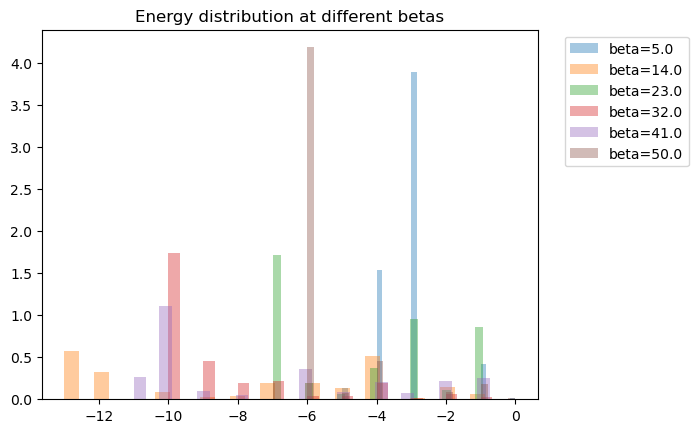

In [11]:
for i, beta in enumerate(beta_list):
    plt.plot(x, ee2_results[i], label=f'beta={beta_list[i]}')
plt.title(f"End to end evolution at different betas")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

for i, beta in enumerate(beta_list):
    plt.plot(x, end_height_results[i], label=f'beta={beta_list[i]}')
plt.title(f"End heigth at different betas")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

for i, beta in enumerate(beta_list):
    plt.plot(x, energy_evolution_results[i], label=f'beta={beta_list[i]}')
plt.title(f"Energy evolution at different betas")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

for i, beta in enumerate(beta_list):
    plt.hist(energy_evolution_results[i], bins=30, density=True, alpha=0.4,label=f'beta={beta_list[i]}')
plt.title(f"Energy distribution at different betas")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()